### 基于Keras的LSTM多变量时间序列预测

> 参考链接：https://blog.csdn.net/qq_28031525/article/details/79046718

学习一下，运行其中的代码

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
def parse(x):
    return datetime.strptime(x,'%Y %m %d %H')
dataset = pd.read_csv('PRSA_data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [4]:
dataset.drop('No', axis=1, inplace=True)

In [5]:
dataset.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### 数据预处理

In [11]:
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]

In [12]:
dataset.to_csv('pollution.csv')

In [13]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### 绘图

In [14]:
import matplotlib.pyplot as plt

values = dataset.values
groups = [0,1,2,3,5,6,7]
plt.figure()
i = 1
for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(values[:,group])
    plt.title(dataset.columns[group],y=0.5,loc='right')
    i += 1
plt.show()

<Figure size 640x480 with 7 Axes>

In [15]:
def series_to_supervised(data,n_in = 1,n_out = 1,dropnan = True):
    # 默认参数只根据t-1预测t
    # 判断是单变量还是多元时间序列
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols,names = list(),list()
    # input sequence
    for i in range(n_in,0,-1):
        cols.append(df.shift(i)) # 整体/所有变量平移
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    # output sequence
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
# header = 0,取第一行为列属性；index_col指定第一列为行索引
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

values = dataset.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [23]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [24]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [25]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


### 划分训练和测试数据集

In [26]:
values = reframed.values
n_train_hours = 365 * 24 # 取第一年的数据训练，剩下4年用来测试
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [27]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [28]:
# reshape input to be 3D [samples, timesteps, features]
# 最终将输入（X）改造为LSTM的输入格式，即[samples,timesteps,features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


### 搭建LSTM模型

In [30]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


W0808 10:34:32.310986  2816 deprecation_wrapper.py:119] From D:\software\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 10:34:32.410992  2816 deprecation_wrapper.py:119] From D:\software\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 10:34:33.194037  2816 deprecation_wrapper.py:119] From D:\software\anaconda\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0808 10:34:33.348046  2816 deprecation.py:323] From D:\software\anaconda\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same b

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0588 - val_loss: 0.0714
Epoch 2/50
 - 0s - loss: 0.0373 - val_loss: 0.0768
Epoch 3/50
 - 0s - loss: 0.0254 - val_loss: 0.0604
Epoch 4/50
 - 0s - loss: 0.0200 - val_loss: 0.0498
Epoch 5/50
 - 0s - loss: 0.0172 - val_loss: 0.0415
Epoch 6/50
 - 0s - loss: 0.0160 - val_loss: 0.0301
Epoch 7/50
 - 0s - loss: 0.0151 - val_loss: 0.0199
Epoch 8/50
 - 0s - loss: 0.0147 - val_loss: 0.0170
Epoch 9/50
 - 0s - loss: 0.0147 - val_loss: 0.0164
Epoch 10/50
 - 0s - loss: 0.0146 - val_loss: 0.0155
Epoch 11/50
 - 0s - loss: 0.0146 - val_loss: 0.0154
Epoch 12/50
 - 0s - loss: 0.0147 - val_loss: 0.0149
Epoch 13/50
 - 0s - loss: 0.0146 - val_loss: 0.0148
Epoch 14/50
 - 0s - loss: 0.0146 - val_loss: 0.0145
Epoch 15/50
 - 0s - loss: 0.0145 - val_loss: 0.0144
Epoch 16/50
 - 0s - loss: 0.0145 - val_loss: 0.0142
Epoch 17/50
 - 0s - loss: 0.0145 - val_loss: 0.0141
Epoch 18/50
 - 0s - loss: 0.0145 - val_loss: 0.0142
Epoch 19/50
 - 0s - loss

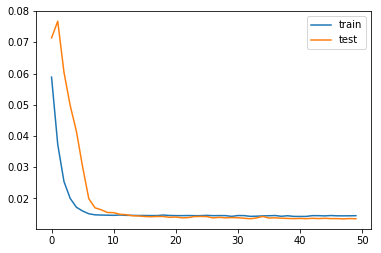

In [32]:
# LSTM模型中，隐藏层有50个神经元，输出层1个神经元（回归问题），输入变量是一个时间步（t-1）的特征，损失函数采用Mean Absolute Error(MAE)，优化算法采用Adam，模型采用50个epochs并且每个batch的大小为72。 
# 参考学习keras：https://blog.csdn.net/mogoweb/article/details/82152174

# design network
model = Sequential()
model.add(LSTM(50,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1)) # 全连接层
model.compile(loss='mae',optimizer='adam') # 选择优化器

# fit model
history = model.fit(train_X,train_y,epochs = 50,batch_size = 72,validation_data = (test_X,test_y),verbose=2,shuffle=False)
# verbose：日志显示
# verbose = 0 为不在标准输出流输出日志信息
# verbose = 1 为输出进度条记录
# verbose = 2 为每个epoch输出一行记录

# plot history
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend() # 右上角的图例
plt.show()

# evaluation
# score = model.evaluate(test_X,test_y,batch_size=72)

# 我们有2000个数据，分成4个batch，那么batch size就是500。运行所有的数据进行训练，完成1个epoch，需要进行4次iterations。

In [37]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

In [41]:
print(yhat[:5])
print(test_X[:5])

[[0.03497014]
 [0.031335  ]
 [0.02073671]
 [0.01967556]
 [0.01918196]]
[[0.0362173  0.33823532 0.1967213  0.83636475 0.33333334 0.12757413
  0.         0.        ]
 [0.03118712 0.33823532 0.1967213  0.83636475 0.         0.006101
  0.         0.        ]
 [0.02012072 0.33823532 0.1967213  0.83636475 0.         0.0145091
  0.         0.        ]
 [0.01911469 0.32352942 0.18032786 0.83636475 0.33333334 0.006101
  0.         0.        ]
 [0.01810865 0.32352942 0.18032786 0.83636475 0.         0.006101
  0.         0.        ]]


In [43]:
# invert scaling for forcast

inv_yhat = concatenate((yhat,test_X[:,1:]),axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [45]:
inv_yhat = inv_yhat[:,0]

In [46]:
# invert scaling for actual
test_y = test_y.reshape(len(test_y),1)
inv_y = concatenate((test_y,test_X[:,1:]),axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [47]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y,inv_yhat))
print('Test RMSE:%.3f' % rmse)

Test RMSE:26.458
